In [220]:
%%bash
set -e

pip install virtualenv

# Create virtual environment
python3 -m virtualenv myenv
source ./myenv/bin/activate
./myenv/bin/pip install ipykernel
./myenv/bin/pip install numpy pandas scikit-learn matplotlib seaborn imblearn
./myenv/bin/pip freeze > requirements.txt
python3 -m ipykernel install --user --name=myenv --display-name "Python3 (myenv)"

created virtual environment CPython3.10.12.final.0-64 in 125ms
  creator CPython3Posix(dest=/home/joao/inatel/P10/C318/Project/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/joao/snap/code/174/.local/share/virtualenv)
    added seed packages: asttokens==2.4.1, comm==0.2.2, contourpy==1.3.1, cycler==0.12.1, debugpy==1.8.8, decorator==5.1.1, distlib==0.3.9, exceptiongroup==1.2.2, executing==2.1.0, filelock==3.16.1, fonttools==4.55.0, imbalanced_learn==0.12.4, imblearn==0.0, ipykernel==6.29.5, ipython==8.29.0, jedi==0.19.2, joblib==1.4.2, jupyter_client==8.6.3, jupyter_core==5.7.2, kiwisolver==1.4.7, matplotlib==3.9.2, matplotlib_inline==0.1.7, nest_asyncio==1.6.0, numpy==2.1.3, packaging==24.2, pandas==2.2.3, parso==0.8.4, pexpect==4.9.0, pillow==11.0.0, pip==24.3.1, platformdirs==4.3.6, prompt_toolkit==3.0.48, psutil==6.1.0, ptyprocess==0.7.0, pure_eval==0.2.3, pygments

In [221]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [222]:
# Criando a função de scorer personalizada (com base no classification_report)
def custom_scorer(y_true, y_pred):
    # Manter o valor de 1 como normal e -1 como anômalo, já que estamos tratando de rótulos do tipo +1 e -1
    y_pred = np.where(y_pred == 1, 1, -1)
    return classification_report(y_true, y_pred, output_dict=True)['recall']

def train(X, Y):
    model = IsolationForest(random_state=42)

    param_grid = {
        'n_estimators': [10, 50, 100, 200, 300, 400],  # Number of trees
        'max_samples': ['auto', 0.5, 0.7],  # Fraction of samples to use for fitting each tree
        'contamination': ['auto', 0.1, 0.25, 0.5],  # Fraction of outliers
        'max_features': [1.0, 0.5]  # Number of features to consider when splitting a node
    }

    scorer = make_scorer(custom_scorer, greater_is_better=True)

    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='precision')

    # Fit
    grid_search.fit(X, Y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    return best_model, best_params

def evaluate(y_pred, y_test):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

### Reading both Datasets

In [223]:
df_full = pd.read_csv('full_cleaned_dataset.csv')
df_night = pd.read_csv('features_night.csv')
df_day = pd.read_csv('features_day.csv')

### Working with Dataset from Night

In [224]:
df_night.columns

Index(['Unnamed: 0', 'state', 'iRms', 'reactivePotency', 'luminosityLux',
       'fail'],
      dtype='object')

In [225]:
df_features_night = df_night.drop(columns=['Unnamed: 0', 'state', 'fail'])
df_features_night.columns

Index(['iRms', 'reactivePotency', 'luminosityLux'], dtype='object')

In [226]:
df_target_night = df_night['fail']
df_target_night.value_counts()

fail
False    744
True     112
Name: count, dtype: int64

In [227]:
df_target_night = pd.Series(np.where(df_target_night, -1, 1), index=df_target_night.index)

In [228]:
model = IsolationForest(random_state=42, contamination=0.05)
y_pred = model.fit_predict(df_features_night)

In [229]:
evaluate(y_pred, df_target_night)

Classification Report:
              precision    recall  f1-score   support

          -1       0.33      0.12      0.18       112
           1       0.88      0.96      0.92       744

    accuracy                           0.85       856
   macro avg       0.60      0.54      0.55       856
weighted avg       0.81      0.85      0.82       856

Confusion Matrix:
[[ 14  98]
 [ 29 715]]


In [230]:
y_pred = pd.DataFrame(y_pred,columns=['predict'])
df_export = pd.concat([df_features_night, y_pred, df_target_night], axis=1)
df_export.to_csv('result_night.csv')

### Working with Dataset from Day

In [231]:
df_day.columns

Index(['Unnamed: 0', 'state', 'iRms', 'reactivePotency', 'luminosityLux',
       'fail'],
      dtype='object')

In [232]:
df_features_day = df_day.drop(columns=['Unnamed: 0', 'state', 'fail'])
df_features_day.columns

Index(['iRms', 'reactivePotency', 'luminosityLux'], dtype='object')

In [233]:
df_target_day = df_day['fail']
df_target_day.value_counts()

fail
False    712
True      96
Name: count, dtype: int64

In [234]:
df_target_day = pd.Series(np.where(df_target_day, -1, 1), index=df_target_day.index)

In [235]:
model = IsolationForest(random_state=42, contamination=0.05)
y_pred = model.fit_predict(df_features_day)

In [236]:
evaluate(y_pred, df_target_day)

Classification Report:
              precision    recall  f1-score   support

          -1       0.12      0.05      0.07        96
           1       0.88      0.95      0.91       712

    accuracy                           0.84       808
   macro avg       0.50      0.50      0.49       808
weighted avg       0.79      0.84      0.81       808

Confusion Matrix:
[[  5  91]
 [ 36 676]]


In [237]:
y_pred = pd.DataFrame(y_pred,columns=['predict'])
df_export = pd.concat([df_features_day, y_pred], axis=1)
df_export.to_csv('result_day.csv')

[ 1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1

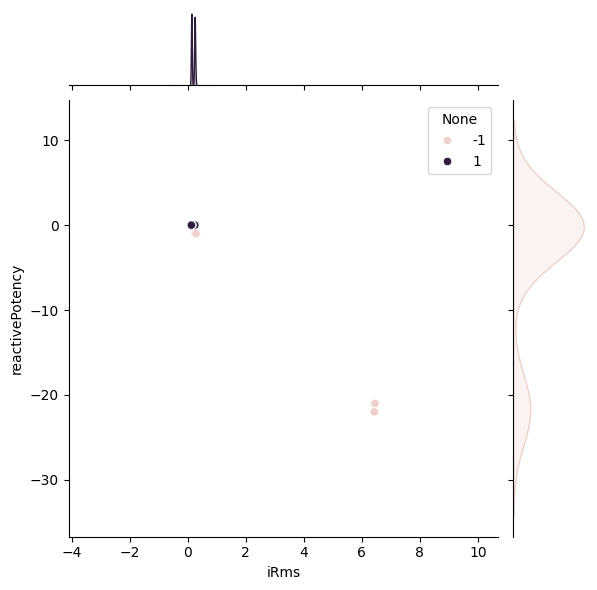

In [238]:
y_pred_np = np.array(y_pred).flatten()
df_features_day['iRms'] = df_features_day['iRms'] / 100
print(y_pred_np)
sns.jointplot(data=df_features_day, x="iRms", y="reactivePotency", hue=y_pred_np)

### Working with full dataset

In [239]:
df_full.columns

Index(['Unnamed: 0', 'timestamp', 'state', 'iRms', 'reactivePotency',
       'luminosityLux', 'fail'],
      dtype='object')

In [240]:
df_features_full = df_full.drop(columns=['timestamp', 'Unnamed: 0', 'state', 'fail'])
df_features_full.columns

Index(['iRms', 'reactivePotency', 'luminosityLux'], dtype='object')

In [241]:
df_target_full = df_full['fail']
df_target_full.value_counts()

fail
False    1456
True      208
Name: count, dtype: int64

In [242]:
df_target_full = pd.Series(np.where(df_target_full, -1, 1), index=df_target_full.index)

In [243]:
model = IsolationForest(random_state=42, contamination=0.05)
y_pred = model.fit_predict(df_features_full)

In [244]:
evaluate(y_pred, df_target_full)

Classification Report:
              precision    recall  f1-score   support

          -1       0.21      0.09      0.12       208
           1       0.88      0.95      0.92      1456

    accuracy                           0.85      1664
   macro avg       0.55      0.52      0.52      1664
weighted avg       0.80      0.85      0.82      1664

Confusion Matrix:
[[  18  190]
 [  66 1390]]


In [245]:
y_pred = pd.DataFrame(y_pred,columns=['predict'])
df_export = pd.concat([df_features_full, y_pred], axis=1)
df_export.to_csv('result_full.csv')

### Tuning the model

In [246]:
best_model, best_params = train(df_features_full, df_target_full)
y_pred = best_model.predict(df_features_full)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, ma

In [247]:
evaluate(y_pred, df_target_full)

Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.29      0.19       208
           1       0.88      0.76      0.81      1456

    accuracy                           0.70      1664
   macro avg       0.51      0.52      0.50      1664
weighted avg       0.79      0.70      0.74      1664

Confusion Matrix:
[[  60  148]
 [ 356 1100]]


In [248]:
best_params

{'contamination': 0.25,
 'max_features': 1.0,
 'max_samples': 0.7,
 'n_estimators': 10}

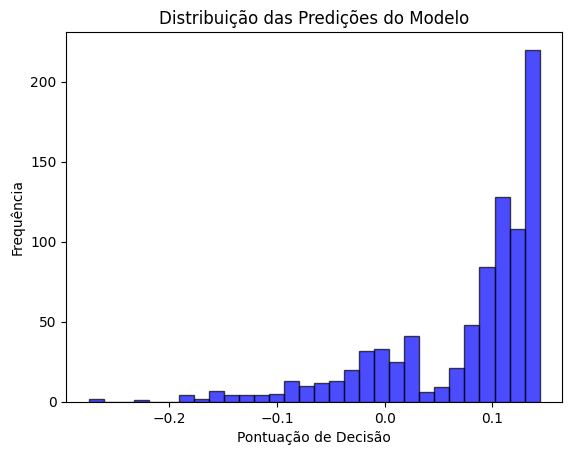

In [249]:
y_pred = best_model.decision_function(df_features_night)

# Gerar o histograma
plt.hist(y_pred, bins=30, alpha=0.7, color='blue', edgecolor='black')  # Ajuste bins conforme necessário

# Configurar o gráfico
plt.title("Distribuição das Predições do Modelo")
plt.xlabel("Pontuação de Decisão")
plt.ylabel("Frequência")

# Mostrar o gráfico
plt.show()

In [250]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Definir o melhor limiar inicial e suas métricas associadas
best_value = -0.3
best_metric = 0

# Métrica escolhida: maximizar o F1-Score (ou outra métrica relevante)
for value in np.arange(-0.5, 0.5, 0.01):
    # Ajustar previsões com base no limiar atual
    y_pred_adjusted = np.where(y_pred >= value, 1, -1)
    
    # Calcular recall, precisão e F1-Score
    precision = precision_score(df_target_night, y_pred_adjusted, pos_label=1)
    recall = recall_score(df_target_night, y_pred_adjusted, pos_label=1)
    f1 = f1_score(df_target_night, y_pred_adjusted, pos_label=1)
    accuracy = accuracy_score(df_target_night, y_pred_adjusted)

    # Escolher a métrica que você quer otimizar (aqui F1-Score)
    metric_to_optimize = f1
    
    # Atualizar o melhor limiar se a métrica melhorar
    if metric_to_optimize > best_metric:
        best_metric = metric_to_optimize
        best_value = value

print(f"Melhor limiar: {best_value}, Melhor métrica: {best_metric}")

Melhor limiar: -0.17999999999999972, Melhor métrica: 0.9323308270676691


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [251]:
y_pred_best = np.where(y_pred >= best_value, 1, -1)

pd.Series(y_pred_best).value_counts()

 1    852
-1      4
Name: count, dtype: int64